In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_bar_igw.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/functions_bar_igw.ipynb

In [2]:
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc" # in numpy .npy format
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_" # including the file name prefix 
path_to_save = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/" # including the file name prefix 

# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset(path_to_input + "01.nc")
ds = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Loading Mask
mask = xr.open_dataset(path_to_mask,drop_variables={"x","y"}) 
mask = mask.tmaskutil[0,:,:].values

Mask, Coarsen, axis, grid2D and filled

In [3]:
ssh_hf = ds.ssh_hf.where(mask==1,np.nan) # change false by 1, otherwise everithing is nan
# print('mask: ok')

ssh_hf = ssh_hf.coarsen(x=4, y=4, boundary='trim').mean()
# print('coarsen: ok')

x_axis = Axis(ssh_hf.x.values,is_circle=True)
y_axis = Axis(ssh_hf.y.values,is_circle=True)
# print('x_axis,y_axis: ok') # t_axis no longer needed    

grid = Grid2D(y_axis, x_axis, ssh_hf.values.transpose(0,1))
# print('grid: ok') 

has_converged, filled = fill.gauss_seidel(grid) # we do not need to transpose, cause we are not concern by t_axis
#print('convergence =', has_converged)
# print('filled: ok')

ssh_hf_filled = ssh_hf.copy(deep=True,data=filled) # is it ok?
# print('copy: ok')

/tmp/ipykernel_257099/2604367313.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_hf_filled.lon, ssh_hf_filled.lat, ssh_hf_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


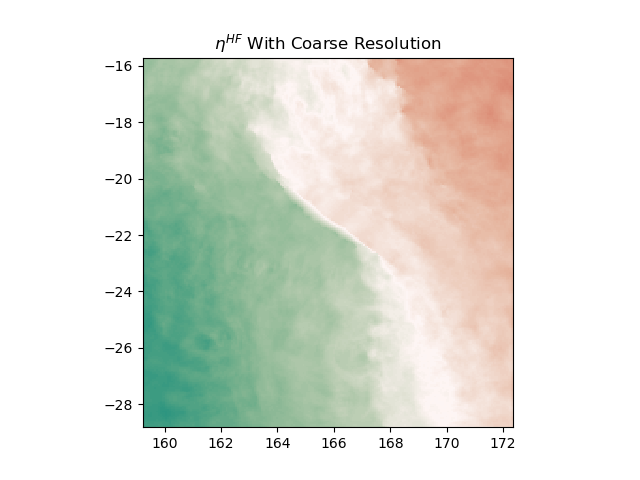

In [4]:
min_val = -1
max_val = 1


plt.figure()
plt.pcolormesh(ssh_hf_filled.lon, ssh_hf_filled.lat, ssh_hf_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.title('$\eta^{HF}$ With Coarse Resolution')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

To cartesian grid

In [5]:
dx = 10 # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:,0].values,
                                                            ssh_hf_filled.lon[0,:].values,
                                                            dx)
# print("#### ENSLAT2D ####")
# print(ENSLAT2D)
# print("#### ENSLON2D #### ")
# print(ENSLON2D)
# print("#### i_lat #### ")
# print(i_lat)
# print("#### i_lon ####")
# print(i_lon)  
  

In [6]:
# Create a new DataArray with the filled data
ssh_hf_filled = xr.DataArray(
    data=filled,
    dims=['y', 'x'],
    coords={'y': ssh_hf.y, 'x': ssh_hf.x, 'lat': (['y', 'x'], ssh_hf.lat.data), 'lon': (['y', 'x'], ssh_hf.lon.data)}
)

dx = 10  # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:, 0].values,
                                                         ssh_hf_filled.lon[0, :].values,
                                                         dx)

ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

points = np.column_stack((ssh_hf_filled.lat.data.flatten(), ssh_hf_filled.lon.data.flatten()))
values = ssh_hf_filled.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))

array_cart_ssh = griddata(points, values, target_grid, method='linear')

array_cart_ssh = array_cart_ssh.reshape(ENSLAT2D.shape)

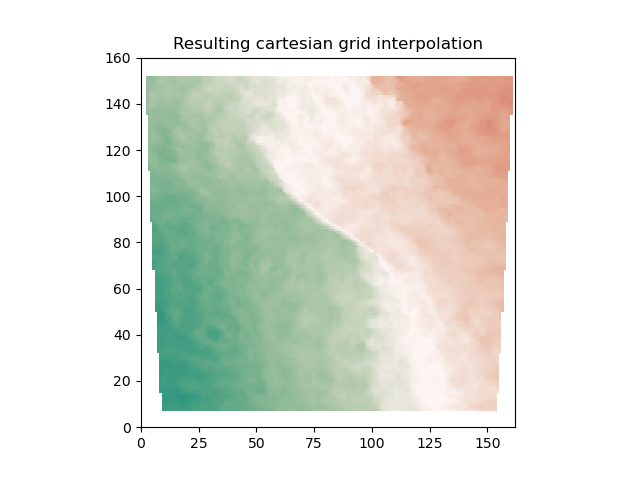

In [7]:
plt.figure()
plt.pcolormesh(array_cart_ssh, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.title('Resulting cartesian grid interpolation')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [8]:
#INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
    
grid = Grid2D(y_axis, x_axis, array_cart_ssh.reshape((i_lat,i_lon)))
has_converged, filled = fill.gauss_seidel(grid)

mask_cart = np.isnan(array_cart_ssh.reshape((i_lat,i_lon)))

cart_ssh_hf = xr.DataArray(data=filled,
                            dims=["y","x"],
                            coords = dict(
                                y=(["y"],np.arange(i_lat)),
                                x=(["x"],np.arange(i_lon))
                            ))

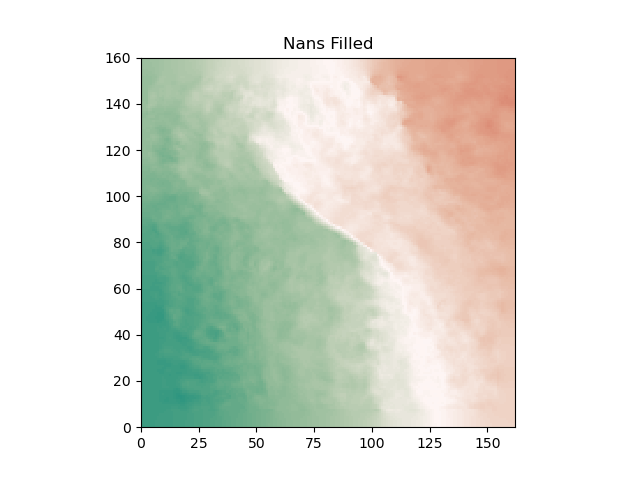

In [9]:
plt.figure()
plt.pcolormesh(filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.title('Nans Filled')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [10]:
# EXTRACTING BAROTROPIC TIDE # 
cart_ssh_filtered = np.array(extract_bar_tide(cart_ssh_hf.values, dx))

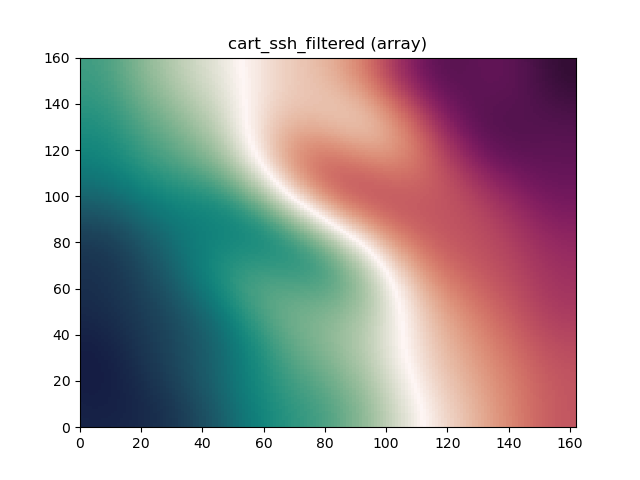

In [11]:
plt.figure()
plt.pcolormesh(cart_ssh_filtered, cmap=cmocean.cm.curl)
plt.title('cart_ssh_filtered (array)')
plt.show()

In [12]:
#lon2d, lat2d = np.meshgrid(ssh_hf.lon.values, ssh_hf.lat.values)
lon2d, lat2d = np.meshgrid(ssh_hf.lon[0,:].values, ssh_hf.lat[:,0].values)

In [13]:
geo_filtered = np.array([griddata(
    np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,  
    cart_ssh_filtered.flatten(),                        
    (lat2d, lon2d),                                       
    method='linear'                                         
)])


geo_filtered_da = xr.DataArray(
    data=geo_filtered[0], 
    dims=["lat", "lon"],   # Dimensions
    coords={"lat": lat2d[:, 0], "lon": lon2d[0, :]},  # Coordinates
    name="geo_filtered"  # Name 
)

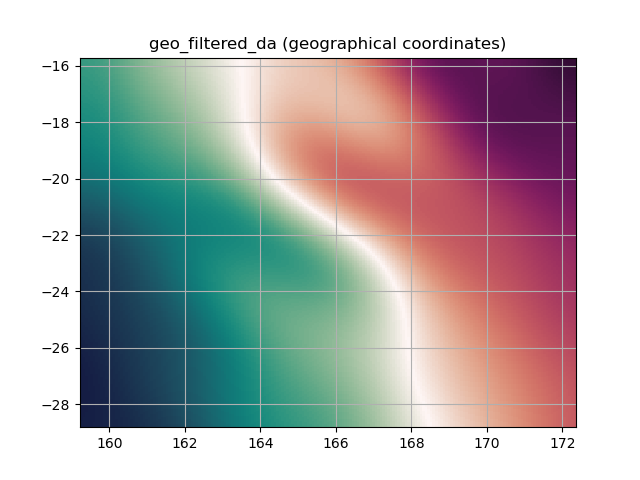

In [14]:
plt.figure()
plt.pcolormesh(geo_filtered_da.lon, geo_filtered_da.lat, geo_filtered_da, cmap=cmocean.cm.curl)
plt.grid(True, which='both')
plt.title('geo_filtered_da (geographical coordinates)')
plt.show()

In [15]:
ssh_igw = ssh_hf_filled - geo_filtered_da_filled

NameError: name 'geo_filtered_da_filled' is not defined

In [ ]:
ssh_igw

<xarray.DataArray (y: 213, x: 197)> Size: 336kB
array([[ 0.00381964,  0.00351807,  0.00280833, ...,  0.01276318,
         0.01616427,  0.01192613],
       [ 0.00075431,  0.00685525,  0.00529611, ...,  0.01453973,
         0.00953861,  0.01528196],
       [-0.0012903 ,  0.00532322,  0.00280832, ...,  0.01647698,
         0.00932599,  0.0146416 ],
       ...,
       [-0.02307543, -0.01277894, -0.01690648, ..., -0.00253651,
        -0.00822654,  0.00018924],
       [-0.02183834, -0.0124345 , -0.01551135, ..., -0.00495727,
        -0.00726415,  0.00945102],
       [-0.022002  , -0.01898177, -0.01398971, ...,  0.00681844,
         0.0114585 ,  0.02039118]])
Coordinates:
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 205 206 207 208 209 210 211 212
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 189 190 191 192 193 194 195 196
    lat      (y, x) float32 168kB -28.78 -28.78 -28.78 ... -15.74 -15.74 -15.74
    lon      (y, x) float32 168kB 159.3 159.3 159.4 159.5 ... 172.2 172.3 172.3

/tmp/ipykernel_4075639/721973003.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_igw.lon, ssh_igw.lat, ssh_igw, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


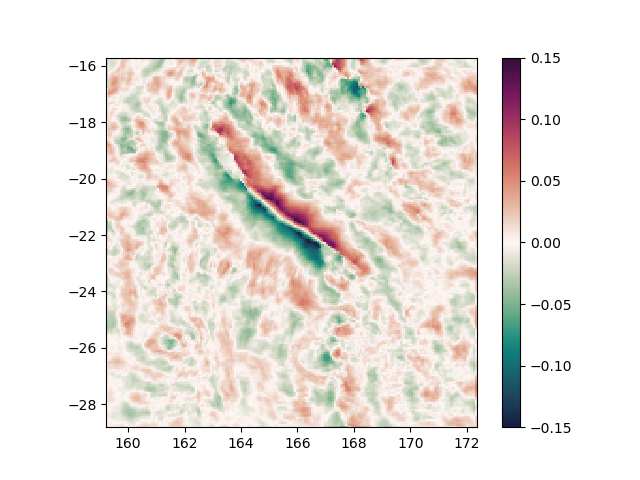

In [ ]:
min_val = -0.15
max_val = 0.15

plt.figure()
plt.pcolormesh(ssh_igw.lon, ssh_igw.lat, ssh_igw, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
